# Deep NLP : TP1:  Plongements de mots (word embeddings)


                                            Emanuela Boros
                                            Christopher Kermorvant

                            “The meaning of a word can be inferred by the company it keeps”

Dans cette série d'exercices, nous allons explorer  différents  plongements (embeddings) de mots :

*  [Collobert & Weston](http://www.jmlr.org/papers/volume12/collobert11a/collobert11a.pdf) https://ronan.collobert.com/senna/
* [Word2Vec Google News](https://code.google.com/archive/p/word2vec/)
* [GloVe](https://nlp.stanford.edu/projects/glove/)
* [FastText](https://github.com/facebookresearch/fastText)

Dans un premier temps, faites d'abord les exercices avec le premier embedding (Collobert et Weston) plus rapide à télécharger puis télécharger les autres et revenez sur les exercices.
    
Nous examinerons les mots les plus proches et visualiserons leurs positions dans l'espaces après réduction de dimension. Puis nous procéderons à des [évaluations](https://arxiv.org/pdf/1801.09536.pdf) qualitatives et intrinsèques des embeddings.

Enfin nous étudierons les raisonnements par analogies que l'on peut conduire par l'arithmétique sur les embeddings (et leurs biais).

Dans le code déjà fourni, ajouter votre code à l'endroit indiqué par `YOUR CODE HERE`.


In [3]:
# basic imports
import os

#import multiprocessing
from multiprocessing import Pool
N_JOBS = 4

# disable warnings for libraries
import warnings
warnings.filterwarnings("ignore")

# scientific python
import numpy as np
import scipy

# graphics
import matplotlib
import matplotlib.pyplot as plt
# display matplotlib graphics in notebook
%matplotlib inline 
import seaborn as sns
# data handling
import pandas as pd
# embedding functions
from polyglot.mapping import Embedding, OrderedVocabulary

# Initialize random number generator for reproducibility
np.random.seed(1337)  

# custom functions
import embeddings
import similarity

# configure logger
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)


03:16:46 DEBUG:backend module://ipykernel.pylab.backend_inline version unknown


## 1. Télécharger des embeddings pré-entraînés

Après téléchargement, les fichiers de données des embeddings sont stockés dans `$HOME/web_data`. Les fichiers ne sont téléchargés que s'ils ne sont pas déjà présents. Après  avoir été téléchargés, les différents embeddings sont des instances de la classe [Embeddings](https://polyglot.readthedocs.io/en/latest/polyglot.mapping.html#module-polyglot.mapping.embeddings) de polyglot. 

In [4]:
# Define which embedding to download

embeddings_download_jobs = []

## Collobert & Weston
embeddings_download_jobs.append(("Collobert & Weston", ["fetch_collobert_and_weston", {}]))

## GloVe
#embeddings_download_jobs.append(("GloVe", ["fetch_GloVe", {"dim": 300, "corpus": "wiki-6B"}]))

## Word2Vec Google News
#embeddings_download_jobs.append(("GoogleNews", ["fetch_SG_GoogleNews", {}]))

## FastText
#embeddings_download_jobs.append(("FastText", ["fetch_FastText", {}]))

In [5]:
for embeddings_name, (method, kwargs) in embeddings_download_jobs:
    # call the function method from the module embeddings 
    word_embeddings = getattr(embeddings, method)(**kwargs)    
    print(embeddings_name, 'embeddings downloaded & loaded')

Collobert & Weston embeddings downloaded & loaded


Une fois que les embeddings sont téléchargés, ils peuvent être appelés par 
```colobert_embedding = embeddings.fetch_collobert_and_weston()```
Ce sont des instances de la classe [Embeddings](https://polyglot.readthedocs.io/en/latest/polyglot.mapping.html#module-polyglot.mapping.embeddings) de polyglot.

## 2. Exploration des embeddings

### Liste des mots les plus proches

L'objectif de cet exercice est de lister les mots les plus proches d'un mot donné pour les différentes embeddings. Après  avoir été téléchargés, les différents embeddings sont des instances de la classe [Embeddings](https://polyglot.readthedocs.io/en/latest/polyglot.mapping.html#module-polyglot.mapping.embeddings) de polyglot. Cette classe possède une méthode `nearest_neighbors` qui retourne les `n` mots les plus proches d'un mot passé en paramètre. 

#### Question 
> * Afficher pour les différents embedding les 5 mots les plus proches des mots suivants : 'mother', 'computer', 'dentist', 'war', 'president', 'secretary', 'nurse'
> * Créer une liste `words_plus_neighbors` contenant les mots et tous leurs voisins (pour la question suivante)

In [7]:
colobert_embedding = embeddings.fetch_collobert_and_weston()

In [8]:
words_plus_neighbors = []
for e in ["mother","computer","dentist","war","president"] :
    l=colobert_embedding.nearest_neighbors(e,top_k=5)
    words_plus_neighbors.append(e)
    words_plus_neighbors.extend(l)
    print("The nearest neigbors of {} are {}".format(e,colobert_embedding.nearest_neighbors(e,top_k=5)))

The nearest neigbors of mother are ['daughter', 'wife', 'father', 'husband', 'sister']
The nearest neigbors of computer are ['laptop', 'multimedia', 'desktop', 'software', 'wiki']
The nearest neigbors of dentist are ['physician', 'midwife', 'pharmacist', 'veterinarian', 'pediatrician']
The nearest neigbors of war are ['revolution', 'death', 'independence', 'court', 'fighting']
The nearest neigbors of president are ['governor', 'chairman', 'mayor', 'secretary', 'senator']


Il est possible d'accéder à la représentation vectorielle d'un mot avec : 
```
colobert_embedding['apple']
```


### Visualisation avec T-SNE

Les embeddings sont des vecteurs de plusieurs centaines de dimensions. Il n'est donc pas possible de les visualiser dans leur espace d'origine. Il est par contre possible d'appliquer des algorithmes de réduction de dimension pour les visualiser en 2 ou 3 dimension. Un des algorithmes de réduction de dimension permettant une visualisation en 2D est [tSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). 

#### Question
> * créer un object `word_vectors` de type `np.array` à partir d'une liste contenant tous les embeddings des mots de la liste `words_plus_neighbors`
> * créer un objet tSNE à partir de la librairie `from sklearn.manifold import TSNE` avec les paramètres `random_state=0`, `n_iter=2000` et `perplexity=15.0` pour une visualisation en 2 dimensions
> * Calculer la transformation tSNE des vecteur `word_vectors` en appliquant la function `.fit_transform(word_vectors)` à l'objet tSNE. Cette fonction estime les paramètres de la transformation tSNE et retourne la représentation en dimension réduite des vecteurs utilisés pour l'estimation.
> * Utiliser la fonction `scatterplot` de [seaborn](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) pour représenter les points en 2 dimensions  et ajouter les labels des mots avec la function `plt.annotate`.

03:17:46 DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to DejaVu Sans ('/home/guyomard/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 2.050000
03:17:46 DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/guyomard/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 2.050000


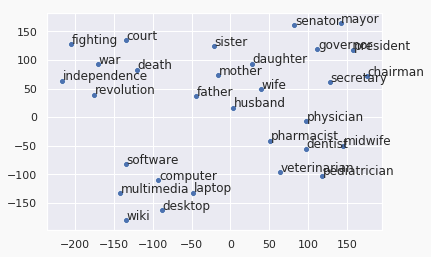

In [9]:
from sklearn.manifold import TSNE

for embeddings_name, (method, kwargs) in embeddings_download_jobs:
    # get the embedding
    word_embeddings = getattr(embeddings, method)(**kwargs)
    

    #retrieve the word representation
    word_vectors = np.array([colobert_embedding[e] for e in words_plus_neighbors])
    

    # create the tSNE transform
    tsne = TSNE(n_components=2,random_state=0, n_iter=2000,  perplexity=15)

    
    # fit and transform the word vectors
    T = tsne.fit_transform(word_vectors)
    
    # plot
    fig = plt.figure()
    fig.patch.set_facecolor('#f9f9f9')

    sns.set(rc={'figure.figsize':(14, 8)})
    sns.set(font_scale=1)

    sns.scatterplot(x=T[:, 0], y=T[:, 1])
    
    for label, x, y in zip(words_plus_neighbors, T[:, 0], T[:, 1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## 3. Evaluation des embeddings 

### Évaluation intrinsèque

[A Survey of Word Embeddings Evaluation Methods](https://arxiv.org/pdf/1801.09536.pdf), Bakarov, 2018.


>les distances entre les mots dans un espace vectoriel pourraient être évaluées à l'aide des jugements heuristiques humains sur les distances sémantiques réelles entre ces mots (par exemple, la distance entre tasse et gobelet définies dans un intervalle continu 0, 1 serait 0.8 puisque ces mots sont synonymes, mais pas vraiment la même chose).



### Téléchargement des datasets pré-établis et annotés manuellement

Nous allons utiliser 4 jeux de données  pour évaluer la qualité des embeddings : [MEN](http://clic.cimec.unitn.it/~elia.bruni/MEN.html), [WS353R](http://www.aclweb.org/anthology/N09-1003.pdf), [SimLex999](http://leviants.com/ira.leviant/MultilingualVSMdata.html) et [MTurk](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.205.8607&rep=rep1&type=pdf). 


Ces jeux de données contiennent des paires de mots dont la proximité sémantique a été évaluée manuellement par des humains. Pour chaque dataset, dataset.X contient une liste de paires de mots et dataset.y contient le score de proximité pour chaque paire.

* MEN, 3 000 paires évaluées par relation sémantique avec une échelle discrète de 0 à 50
* SimLex-999, 999 paires évaluées avec un fort respect pour la similarité sémantique avec une échelle de 0 à 10
* MTurk-287, 287 paires évaluées par relation sémantique avec une échelle de 0 à 5
* WordSim-353, 353 paires évaluées par similarité sémantique (cependant, certains chercheurs trouvent les instructions pour les évaluateurs ambiguës en ce qui concerne la similarité et l'association) sur une échelle de 0 à 10

In [24]:
similarity_tasks = {
    "MEN": similarity.fetch_MEN(),
    "WS353R": similarity.fetch_WS353(which="relatedness"),
    "SimLex999": similarity.fetch_SimLex999(),
    "MTurk": similarity.fetch_MTurk(),
}

for name, dataset in similarity_tasks.items():
    print('\n', name, ':',len(dataset.X),'items')
    for data, score in zip(dataset.X[:4], dataset.y[:4]):
        print(' '*4, ', '.join(data), ':', score)


Dataset created in /home/guyomard/web_data/similarity


 MEN : 3000 items
     sun, sunlight : [10.]
     automobile, car : [10.]
     river, water : [9.8]
     stair, staircase : [9.8]

 WS353R : 252 items
     computer, keyboard : 7.62
     Jerusalem, Israel : 8.46
     planet, galaxy : 8.11
     canyon, landscape : 7.53

 SimLex999 : 999 items
     old, new : 1.58
     smart, intelligent : 9.2
     hard, difficult : 8.77
     happy, cheerful : 9.55

 MTurk : 287 items
     episcopal, russia : 5.5
     water, shortage : 5.428571428
     horse, wedding : 4.533333334
     plays, losses : 6.4


### Résultats évaluation intrinsèque

Notre objectif est de comparer les similarités entre les paires de mots des datasets calculées à partir des embeddings et celles données par les annotateurs humains. Si un embedding prédit les similarités de la même manière que les humains, on estime qu'il est bon. On peut donc calculer la corrélation entre la proximité donné par l'embedding et celle donnée par les humains pour chaque paire de mots du dataset.

#### Question

> * pour chaque embedding et chaque dataset (MEN, WS353R, SimLex999 et MTurk), calculer la similarité entre les proximités données par l'embedding et celles données par les humains. On utilisera la fonction `similarity.evaluate_similarity(word_embeddings, dataset.X, dataset.y)` qui renvoit le coefficient de correlation de Spearman.
> * stocker les scores  pour chaque embedding et chaque dataset dans une liste `similarity_results = []` sous forme d'un dictonnaire : `similarity_results.append({'Embeddings': embeddings_name, 'Dataset': name, 'Score': score})`


In [25]:
similarity_results = []

for embeddings_name, (method, kwargs) in embeddings_download_jobs:
    # get the embedding
    word_embeddings = getattr(embeddings, method)(**kwargs)
    
    for name, dataset in similarity_tasks.items():
        score=similarity.evaluate_similarity(word_embeddings, dataset.X, dataset.y)
        similarity_results.append({'Embeddings': embeddings_name, 'Dataset': name, 'Score': score})



### Visualisation des résultats de similarité

Le code suivant permet de visualiser les coefficients de corrélation pour chaque dataset sur les différents jeux de test.

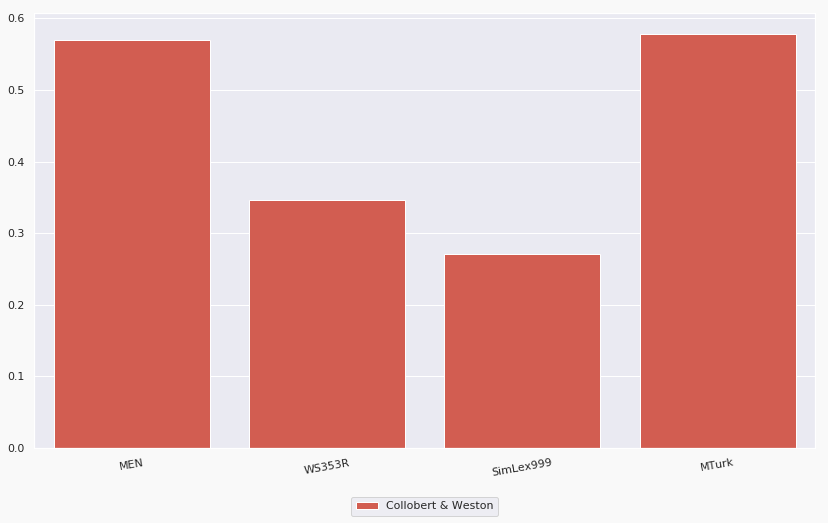

In [26]:
import pandas as pd


df = pd.DataFrame.from_dict(similarity_results, orient='columns')
df

fig = plt.figure()
fig.patch.set_facecolor('#f9f9f9')



sns.set(rc={'figure.figsize':(8, 6)})
sns.set(font_scale=1)

colors = ["#e74c3c", "#75d9fc", "#b4e0ef", "#34495e", "#e74c3c", "#2ecc71"]
ax = sns.barplot(x="Dataset", y="Score", hue="Embeddings", data=df, errwidth=0, palette=sns.color_palette(colors))
#ax = sns.barplot(x="Dataset", y="value", hue="Dataset", data=df, errwidth=0, palette=sns.color_palette(colors))  #, palette=palette GnBu_d


ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=3, fancybox=True, shadow=False)
ax.set_xticklabels(df['Dataset'], rotation=10)
ax.set(xlabel="", ylabel="")

plt.show()

## Évaluation d'analogies

Notre objectif est maintenant d'explorer les relations sémantiques induites par l'arithmétique sur les embeddings. Nous allons donc explorer les analogies induites par les embeddings sous forme de raisonnement du type : "l'homme est au roi ce que la femme est à ?", la réponse étant "la reine". On peut calculer la réponse avec les représentations fournies par l'embedding par :  

`v = vecteur(roi)-vecteur(homme)+vecteur(femme)`. 

La réponse étant alors le mot dont la représentation est la plus proche du vecteur `v`. Pour trouver le mot dont le vecteur est le plus proche de `v`, il faut définir une distance dans l'espace des embeddings. Nous utiliserons la [similarité cosinus](https://fr.wikipedia.org/wiki/Similarit%C3%A9_cosinus)

#### Question
>* Implémenter la similarity cosinus à l'aide des fonctions [np.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html#numpy.dot) et [np.linalg.norm](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm)
>* Appliquer le calcul d'analogies sur les triplets proposés ou ceux de votre choix. Observez-vous [ce phénomène](https://arxiv.org/pdf/1607.06520.pdf) ?

In [27]:
def my_cosine_similarity(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

def sorted_by_similarity(word_embeddings, base_vector):
    """Returns words sorted by cosine distance to a given vector, most similar first"""
    words_with_distance = [(my_cosine_similarity(base_vector, word_embeddings[w]), w) 
                           for w in word_embeddings.vocabulary]

    return sorted(words_with_distance, key=lambda t: t[0], reverse=True)

def is_redundant(word):
    return (
        word_1.lower() in word.lower() or
        word_2.lower() in word.lower() or
        word_3.lower() in word.lower())


pairs = [(['man', 'woman'], 'king'), 
         (['man', 'programmer'], 'woman'), 
         (['father', 'doctor'], 'mother'),
         (['father', 'facebook'], 'mother')
        ]

words_and_responses = []
for embeddings_name, (method, kwargs) in embeddings_download_jobs:
    # get the embedding
    word_embeddings = getattr(embeddings, method)(**kwargs)
    
    for pair in pairs:
        word_1, word_2, word_3 = pair[0][0], pair[0][1], pair[1]
        
        closest = sorted_by_similarity(word_embeddings, 
                                       word_embeddings[word_2] - word_embeddings[word_1] + 
                                       word_embeddings[word_3])[:10]

        closest = [(dist, w) for (dist, w) in closest if not is_redundant(w)] #
        
        print("{} + {} - {} = ? {}".format(word_2, word_3, word_1, closest[0][1]))
        words_and_responses += [word_1, word_2, word_3,closest[0][1]]

woman + king - man = ? princess
programmer + woman - man = ? blogger
doctor + mother - father = ? nurse
facebook + mother - father = ? yahoo


Oui on observe ce phenomene, c'est biaisé.

### Visualisation des analogies

Les relations d'analogies peuvent se visualiser dans l'espace des embeddings après réduction de dimension, par exemple avec tSNE.

12:23:14 DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.3 to DejaVu Sans ('/home/guyomard/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 2.050000
12:23:14 DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.600000000000001 to DejaVu Sans ('/home/guyomard/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 2.050000


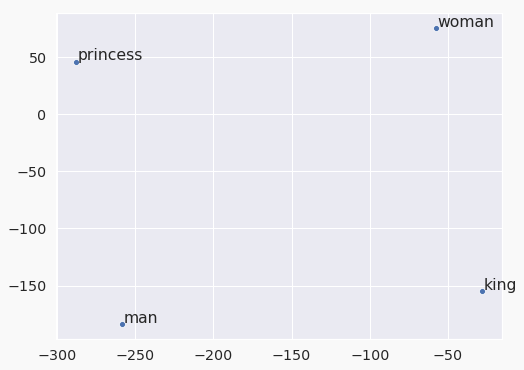

In [28]:
for embeddings_name, (method, kwargs) in embeddings_download_jobs:
    # get the embedding
    word_embeddings = getattr(embeddings, method)(**kwargs)
    
    word_vectors = np.array([word_embeddings[word] for word in words_and_responses[:4]])

    
    tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=5.0)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(word_vectors)
    
    fig = plt.figure()
    fig.patch.set_facecolor('#f9f9f9')

    sns.set(rc={'figure.figsize':(6, 6)})
    sns.set(font_scale=1.3)

    sns.scatterplot(x=T[:, 0], y=T[:, 1])
    
    for label, x, y in zip(words_and_responses, T[:, 0], T[:, 1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')